<a href="https://colab.research.google.com/github/AShipulin/Train-Scheduler-Simulator-SimPy/blob/main/TrainSchedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# График движения поездов

График движения поездов строится с использованием дискретно-событийного имитационного моделирования.

Для построения используется библиотека SimPy.
В библиотеке существую "общие ресурсы" (PriorityResource), что подходит для принципов построения.

SimPy. Discrete event simulation for Python
* https://simpy.readthedocs.io/en/latest/
* https://pypi.org/project/simpy/
* https://gitlab.com/team-simpy/simpy/

## Установка simpy и необходимых библиотк

In [1]:
!pip install -U simpy
import simpy
import pandas as pd
from matplotlib import pyplot as plt

## Орисовываем построенный график движения поездов

In [2]:
# Орисовываем построенный график движения поездов
def gts(trainSchedule):

    #df = pd.DataFrame(data_log, columns=["train", "s_beg", "s_end", "t_beg", "t_end"])

    # Добавим имена колонок
    df_trainSchedule = pd.DataFrame(trainSchedule, columns=["train", "sta", "time"])

    # Создайте фигуру, содержащую одну ось
    fig, ax = plt.subplots()

    # Оси времени
    time_max = df_trainSchedule['time'].max()
    for i in range(10, time_max, 10):
        if i%30 > 0:
            ax.axvline(x=i, linestyle='--', linewidth=1)
    for i in range(30, time_max, 30):
        if i%60 > 0:
            ax.axvline(x=i, linestyle='-.', linewidth=1)
    for i in range(0, time_max, 60):
        ax.axvline(x=i, linestyle='-')

    # Оси станций
    df_sta = df_trainSchedule.drop_duplicates(subset=['sta'])
    plt.yticks(df_sta['sta'])
    for index, row in df_sta.iterrows():
        ax.axhline(y=row['sta'])

    # Подписи
    plt.xlabel('Время, x')
    plt.ylabel('Станции, y')
    plt.title("График движения поездов")

    # Отключаем линии
    for sp in ['top', 'bottom', 'right', 'left']:
        ax.spines[sp].set_visible(False)

    # Рисуем нитки поездов
    df_train = df_trainSchedule.groupby(['train']).first()
    for train, row in df_train.iterrows():
        t = df_trainSchedule[(df_trainSchedule['train'] == train)]
        y = t['sta']
        x = t['time']
        ax.plot(x, y, label = train, color='black')
        if train%2 == 1:
            ax.text(row['time'], row['sta']-0.3, train, rotation=-75.)
        else:
            ax.text(row['time']-5, row['sta'], train, rotation=75.)
        #ax.legend()

    plt.show()

#gts(trainSchedule)

In [3]:
# Функция сбора логов по ресурсу
def queue_logger(resource, t_step=1):
    while True:
        # Каждый так добавляем
        item = (
            env.now, # Текущее время
            resource.count, # Использованное число ресурсов
            len(resource.queue) # Дина очереди
        )
        queue_log.append(item)
        # len(manager.queue) - длина очери
        # manager.count - число задействованых менеджеров
        yield env.timeout(t_step)

In [4]:
# Функция завершения интервала по рассписанию
# Интервал длиться долше чем операция с поездом,
# поэтому завершаем его за границами операции движения по перегону
def queue_exec(t_step=1):
    while True:
        for i in range(len(intScr)):
            if (intScr[i][0] == env.now):
                resInt1 = intScr[i][1]
                reqInt1 = intScr[i][2]
                resInt1.release(reqInt1)
        yield env.timeout(t_step)

## Вводные

Полуавтоблокирка - повзовляет отправлять только один поезд на путь перегона
в попутном направлении, при этом должен выполняться интервал попутного следования.

## Станционные интервалы

Однопутный участок из четырех станйий s1,...s4 и трех перегонов p1, p2, p3
оброудованых полуавтоблокировкой*. На встречу одноврменно отправляется два поезда.

### Задача 1. Интервал срещения


Необходимо обспечить выполнение интервала скрщения поездов при встрече поездов.
Время хода поездов по перегонам 10 минут, не учитвается разгон и замедление.
Интервал срещения 1 минута.


В будщем нудно учесть:
- Время на рзгон
- Приоритеты очередности поездов
- Дифиренсацию интервла разных категорий поездов
- Количесто путей на станции для четных / нечетных поездов


```
-> Чет.              Неч. <-

Поеезд 2002 ->  <- Поезд 2001

s0       s1       s2       s3
|--------|--------|--------|
    p0       p1       p2
is00    is10     is20     is30
is01    is11     is21     is31
```

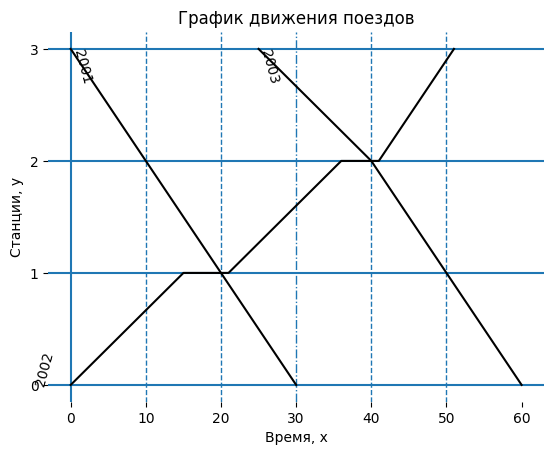

In [5]:
# Списки для сбора метрик
trainSchedule = [] # График двиджения поездов [Поеезд, Станция, Время]
rwayBusy = {}
intScr = []
data_log = []
queue_log = []

# Получаем среду
env = simpy.Environment()

# Станци (не использовал)
s1 = simpy.PriorityResource(env, capacity=5)
s2 = simpy.PriorityResource(env, capacity=3)
s3 = simpy.PriorityResource(env, capacity=3)
s4 = simpy.PriorityResource(env, capacity=5)

# Перегоны
p1 = simpy.PriorityResource(env, capacity=1)
p2 = simpy.PriorityResource(env, capacity=1)
p3 = simpy.PriorityResource(env, capacity=1)

# Интервал скрещения в четном напрвлении
is00 = simpy.PriorityResource(env, capacity=1)
is10 = simpy.PriorityResource(env, capacity=1)
is20 = simpy.PriorityResource(env, capacity=1)
is30 = simpy.PriorityResource(env, capacity=1)

# Интервал скрещения в нечетном напрвлении
is01 = simpy.PriorityResource(env, capacity=1)
is11 = simpy.PriorityResource(env, capacity=1)
is21 = simpy.PriorityResource(env, capacity=1)
is31 = simpy.PriorityResource(env, capacity=1)

resRWays = [p1, p2, p3]
resIScrs = ([is00, is10, is20, is30],
           [is01, is11, is21, is31])

class TrainSchedule():

    # Инициализация
    def __init__(self, env, resRWays, resIScrs):
        self.env = env
        self.resRWays = resRWays
        self.resIScrs = resIScrs

    # Движение в чтную сторону
    def driving0(self, train, wait, prio, rway):

        sta = rway
        staNext = rway + 1  # Следющая станция
        rwayNext = rway + 1 # Следющий путь перегон

        resRWay = self.resRWays[rway]
        resRWayNext = self.resRWays[rwayNext] if len(resRWays) > rwayNext else None
        resIScrs1 = self.resIScrs[1][sta]     # Проверяем
        resIScrs0 = self.resIScrs[0][staNext] # Занимаем

        # Осовбождаем перегон, если мы заняли
        if not rwayBusy.get(rway) is None:
            req = rwayBusy.get(rway)[2]
            resRWay.release(req)

        # Занимаем интервал
        reqInt0 = resIScrs0.request(priority=-1)

        # Ждем особождения перегона, интервала
        with (resRWay.request(priority=prio) as reqPer,
              resIScrs1.request(priority=prio) as reqInt1):
            yield reqPer & reqInt1

            # Начало занятия перегона
            beg = self.env.now
            trainSchedule.append([train, sta, env.now])

            # Едем по прегону
            yield self.env.timeout(10)

            # Замедление
            if not resRWayNext is None:
                if resRWayNext.count > 0:
                    yield self.env.timeout(5)
                else:
                    reqPerN = resRWayNext.request(priority=-1)
                    rwayBusy[rwayNext] = [train, resRWayNext, reqPerN]

            # Конец занятия перегона
            data_log.append([train, sta, staNext, beg, self.env.now])
            trainSchedule.append([train, staNext, self.env.now])

            # Регестрируем время особождения интервала
            intScr.append([self.env.now+1, resIScrs0, reqInt0])

    # Движение в нечтную сторону
    def driving1(self, train, wait, prio, rway):

        sta = rway + 1
        staNext = rway
        rwayNext = rway - 1

        resRWay = self.resRWays[rway]
        resRWayNext = self.resRWays[rwayNext] if -1 < rwayNext  else None
        resIScrs0 = self.resIScrs[0][sta]     # Проверяем
        resIScrs1 = self.resIScrs[1][staNext] # Занимаем

        # Осовбождаем перегон, если мы заняли
        if not rwayBusy.get(rway) is None:
            req = rwayBusy.get(rway)[2]
            resRWay.release(req)

        # Занимаем интервал
        reqInt1 = resIScrs1.request(priority=-1)

        # Ждем особождения перегона, интервала
        with (resRWay.request(priority=prio) as reqPer,
              resIScrs0.request(priority=prio) as reqInt0) :
            yield reqPer & reqInt0

            # Начало занятия перегона
            beg = self.env.now
            trainSchedule.append([train, sta, env.now])

            # Едем по прегону
            yield self.env.timeout(10)

            # Замедление
            if not resRWayNext is None:
                if resRWayNext.count > 0:
                    yield self.env.timeout(5)
                else:
                    reqPerN = resRWayNext.request(priority=-1)
                    rwayBusy[rwayNext] = [train, resRWayNext, reqPerN]

            # Конец занятия перегона
            data_log.append([train, sta, staNext, beg, env.now])
            trainSchedule.append([train, staNext, self.env.now])

            # Регестрируем время особождения интервала
            intScr.append([self.env.now+1, resIScrs1, reqInt1])

    # Четный поезд
    def train0(self, train, wait, prio):

        yield self.env.timeout(wait)

        op0 = self.env.process(self.driving0(train, wait=0, prio=10, rway=0))
        yield op0
        op1 = self.env.process(self.driving0(train, wait=0, prio=10, rway=1))
        yield op1
        op2 = self.env.process(self.driving0(train, wait=0, prio=10, rway=2))
        yield op2

    # Нечетный поезд
    def train1(self, train, wait, prio):

        yield self.env.timeout(wait)

        op0 = self.env.process(self.driving1(train, wait=0, prio=10, rway=2))
        yield op0
        op1 = self.env.process(self.driving1(train, wait=0, prio=10, rway=1))
        yield op1
        op2 = self.env.process(self.driving1(train, wait=0, prio=10, rway=0))
        yield op2

# Запускаем процесс логирования
#env.process(queue_logger(is11))

# Запускаем процесс завершения интервалов
env.process(queue_exec())

ts = TrainSchedule(env, resRWays, resIScrs)

# Запускаем одноврменно поезда
t2001 = env.process(ts.train1(train=2001, wait=0, prio=0))
t2002 = env.process(ts.train0(train=2002, wait=0, prio=0))
t2003 = env.process(ts.train1(train=2003, wait=25, prio=0))
#t2004 = env.process(ts.train0(train=2004, wait=25, prio=0))
#t2005 = env.process(ts.train1(train=2005, wait=55, prio=0))
#t2006 = env.process(ts.train0(train=2006, wait=55, prio=0))

# Выполняем расчет
env.run(until=200)

# Выводим график
gts(trainSchedule)

# Отлада. Смотрим занятость от интервала
#queue_df = pd.DataFrame(queue_log, columns=["time", "queue count" , "queue length"] )
#from matplotlib import pyplot as plt
#plt.stairs(queue_df["queue count"], hatch='x')